## Answer questions

In [772]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [773]:
import pandas as pd
from src.paths import TRANSFORMED_DATA_DIR, MODELS_DIR, RAW_DATA_DIR

In [774]:
# Read metadata json file from models folder
import json

metadata = json.load(open(MODELS_DIR / 'metadata.json'))

In [775]:
print(f'Model being used is: {metadata["name"]}')

Model being used is: Linear regression model


In [776]:
if metadata['name'] == 'Linear regression model':
    data = pd.read_csv(TRANSFORMED_DATA_DIR / 'transformed_data_for_lr.csv')
    data_no_dummies = pd.read_csv(TRANSFORMED_DATA_DIR / 'transformed_data.csv')
else:
    data = pd.read_csv(TRANSFORMED_DATA_DIR / 'transformed_data.csv')

In [777]:
data.shape

(4817, 137)

In [778]:
# Convert date columns to datetime
data['registration_date'] = pd.to_datetime(data['registration_date'])
data['sold_at'] = pd.to_datetime(data['sold_at'])

In [779]:
# Change data types from object to categorical
from src.data import convert_object_columns_to_category

data = convert_object_columns_to_category(data)

In [780]:
from src.data import get_train_test_data

In [781]:
features = metadata['features']
target = metadata['target']

In [782]:
# Print the features
features

['mileage',
 'engine_power',
 'feature_1',
 'feature_2',
 'feature_3',
 'feature_4',
 'feature_5',
 'feature_6',
 'feature_7',
 'feature_8',
 'age_in_months_when_sold',
 'model_key_114',
 'model_key_116',
 'model_key_118',
 'model_key_120',
 'model_key_123',
 'model_key_125',
 'model_key_135',
 'model_key_214 Gran Tourer',
 'model_key_216',
 'model_key_216 Active Tourer',
 'model_key_216 Gran Tourer',
 'model_key_218',
 'model_key_218 Active Tourer',
 'model_key_218 Gran Tourer',
 'model_key_220',
 'model_key_220 Active Tourer',
 'model_key_225',
 'model_key_225 Active Tourer',
 'model_key_316',
 'model_key_318',
 'model_key_318 Gran Turismo',
 'model_key_320',
 'model_key_320 Gran Turismo',
 'model_key_325',
 'model_key_325 Gran Turismo',
 'model_key_328',
 'model_key_330',
 'model_key_330 Gran Turismo',
 'model_key_335',
 'model_key_335 Gran Turismo',
 'model_key_418 Gran Coupé',
 'model_key_420',
 'model_key_420 Gran Coupé',
 'model_key_425',
 'model_key_430',
 'model_key_430 Gran C

In [783]:
X, y, X_train, X_test, y_train, y_test = get_train_test_data(data, features, target)

In [784]:
import joblib

In [785]:
# Load the model
model = joblib.load(MODELS_DIR / 'model.pkl')

In [786]:
# Print the model
model

LinearRegression()

### Q1

In [787]:
# Read feature importance df from models folder
feature_importance = joblib.load(MODELS_DIR / 'feature_importance_df.pkl')

In [788]:
# In the case of linear regression these are the coefficients
feature_importance

,feature,importance
85,model_key_i8,41915.689401
132,model_initial_i,18114.456595
72,model_key_M4,17419.646513
82,model_key_X6 M,12244.834983
62,model_key_640 Gran Coupé,10403.508345
...,...,...
70,model_key_M235,-9023.072766
76,model_key_X3,-9259.586201
75,model_key_X1,-12816.407426
63,model_key_650,-17718.921801


In [789]:
import shap

# print the JS visualization code to the notebook
shap.initjs()

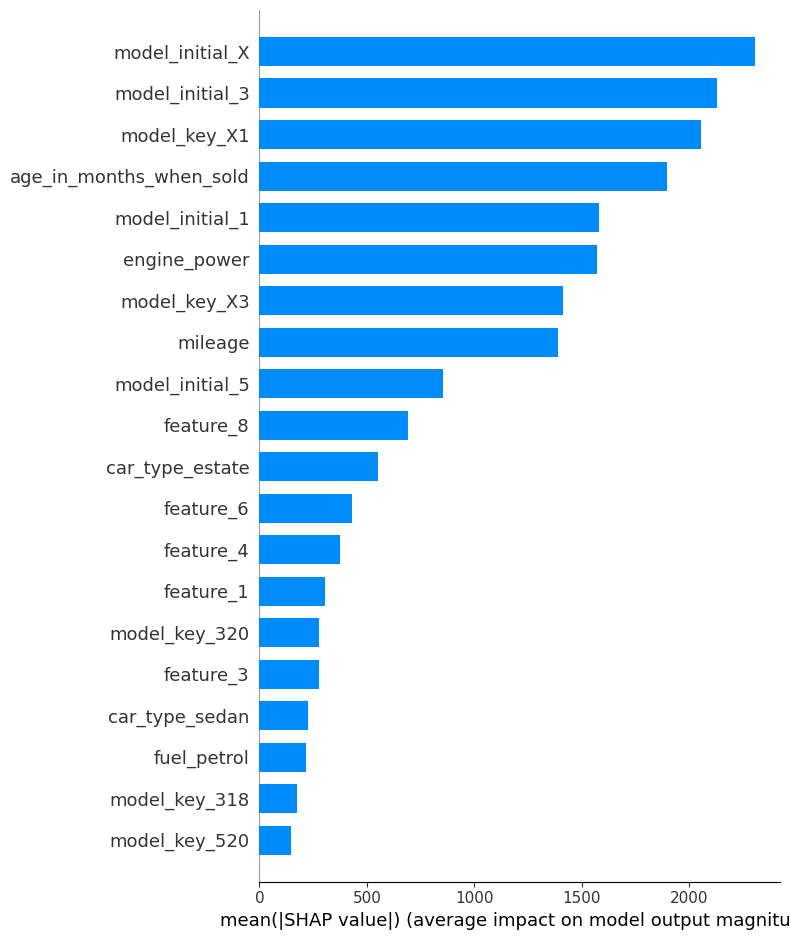

In [790]:
if 'XGBoost linear' in metadata["name"]:
    print('Linear model detected. Shap explanation not supported.')
elif 'Linear regression model' in metadata["name"]:
    explainer = shap.LinearExplainer(model, X)
    shap_values = explainer.shap_values(X)
    shap.summary_plot(shap_values, X, feature_names=features, plot_type='bar')
elif 'XGBoost with trees' in metadata["name"]:
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X)
    shap.summary_plot(shap_values, X, feature_names=features, plot_type='bar')
else:
    raise ValueError('Model type not supported')

### Q2

As found during the data exploration phase:
- Except for feature_7, cars with True in the other car features have in average higher prices than cars without them. This suggests that these features will be important for predictive models.
- There seems to be a peak average price in Aug 2018. This may be caused by a sale of a highly price car precisely this month.
- Hybrid and electrical cars are more expensive on average.
- Electrical cars average prices were stable from winter to summer, and were not sold in autumn.
- Diesel and petrol cars had similar average prices, although petrol cars had a drop in average prices starting summer 2018.
- The most expensive car type is, on average, suv, although coupe was most expensive at the start of the year and then dropped below suv also starting in summer.
- Coupe and convertible cars were, on average, more expensive in winter than in summer.
- Vans where more expensive, on average, in spring, summer, and autumn, than in winter.
- Subcompact had generally the lowest average prices.
- Paint color does not seem to generally determine or be associated with the average price, except for color green, which consistently had prices much lower than other colors. Maybe not very popular.
- Orange and white cars were sold for more, on average, during summer than during winter and spring.
- Red cars were the opposite, with lower average prices during summer than during winter and spring.

Find similar observations using estimated price instead of real price

In [791]:
pred = model.predict(X)

In [792]:
if metadata['name'] == 'Linear regression model':
    data_q2 = data_no_dummies.copy()
else:
    data_q2 = data.copy()

In [793]:
data_q2['price'] = pred

In [794]:
from src.plots import plot_avg_target_time_series_by_features

In [795]:
# Load car features
car_features = joblib.load(RAW_DATA_DIR / 'car_features.pkl')

In [796]:
plot_avg_target_time_series_by_features(data_q2, car_features)

In [797]:
# Load small cardinality features
small_cardinality_features = joblib.load(RAW_DATA_DIR / 'small_cardinality_features.pkl')

In [798]:
plot_avg_target_time_series_by_features(data_q2, small_cardinality_features)

In [799]:
from src.questions import make_ttest_results_df

In [800]:
grouping_column = 'season_sold_at'
group_1 = 'winter'
group_2 = 'summer'
ttest_df = make_ttest_results_df(data_q2, small_cardinality_features, grouping_column, group_1, group_2)

In [801]:
ttest_df.sort_values(by='p_val')

,feature,feature_value,t_stat,p_val
8,car_type,sedan,4.298368,0.000020
5,car_type,coupe,2.609239,0.012519
14,paint_color,white,-2.454245,0.014769
6,car_type,estate,2.095263,0.036482
11,car_type,van,-1.961954,0.066353
1,fuel,petrol,1.671414,0.098922
4,car_type,convertible,1.570950,0.131881
10,car_type,suv,-1.353913,0.176267
20,paint_color,brown,-0.936335,0.350486
9,car_type,subcompact,0.898433,0.373958


### Q3

In [802]:
today_date = '3/1/2024'

In [803]:
data_q3 = data.copy()

In [804]:
# Convert date columns to datetime and mock the sold_at date as today's date
data_q3['registration_date'] = pd.to_datetime(data_q3['registration_date'])
data_q3['sold_at'] = today_date
data_q3['sold_at'] = pd.to_datetime(data_q3['sold_at'])

In [805]:
# Calculate mileage per month
data_q3['mileage_per_month'] = data_q3['mileage'] / data_q3['age_in_months_when_sold']

In [806]:
# Calculate age in month at today date and replace in data_q3
data_q3['age_in_months_when_sold'] = (data_q3['sold_at'].dt.to_period('M') - data_q3['registration_date'].dt.to_period('M')).apply(lambda x: x.n)

In [807]:
# Update estimated mileage at today date
data_q3['mileage'] = data_q3['age_in_months_when_sold'] * data_q3['mileage_per_month']

In [808]:
data_q3[['registration_date', 'sold_at', 'age_in_months_when_sold', 'mileage']].head()

,registration_date,sold_at,age_in_months_when_sold,mileage
0,2012-02-01,2024-03-01,145,286754.859155
1,2016-04-01,2024-03-01,95,60147.954545
2,2012-04-01,2024-03-01,143,374449.585714
3,2014-07-01,2024-03-01,116,345396.744186
4,2014-12-01,2024-03-01,111,269444.175000


In [809]:
X_q3, y_q3, X_train_q3, X_test_q3, y_train_q3, y_test_q3 = get_train_test_data(data_q3, features, target)

In [810]:
# Get estimated prices today
pred_q3 = model.predict(X_q3)

In [811]:
# Add 1 year to the age_in_months_when_sold
X_q3['age_in_months_when_sold'] = X_q3['age_in_months_when_sold'] + 12

In [812]:
# Add 1 year worth of mileage
X_q3['mileage'] = X_q3['mileage'] + 12 * data_q3['mileage_per_month']

In [813]:
# Get estimated prices 1 year later
pred_q3_one_year_later = model.predict(X_q3)

In [814]:
X_q3['price_today'] = pred_q3
X_q3['price_one_year_later'] = pred_q3_one_year_later
X_q3['loss'] = X_q3['price_today'] - X_q3['price_one_year_later'] 

In [815]:
price_today_threshold = 20000
loss_threshold = 2000

In [816]:
# Indentify cars that are candidates for buying
candidate_cars = X_q3[(X_q3['price_today'] >= price_today_threshold) & (X_q3['loss'] <= loss_threshold)]

In [817]:
# Show top 10 candidate cars with lowest loss
candidate_cars.sort_values('loss').head(10)

,mileage,engine_power,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,...,model_initial_6,model_initial_7,model_initial_A,model_initial_M,model_initial_X,model_initial_Z,model_initial_i,price_today,price_one_year_later,loss
4346,3090.600000,183,True,True,False,False,False,False,True,True,...,False,False,False,False,True,False,False,30618.084320,29450.491413,1167.592907
3910,9278.857143,155,True,True,False,True,True,True,True,True,...,False,False,False,False,True,False,False,31751.664627,30558.012975,1193.651651
4121,13241.250000,423,True,True,True,False,False,False,True,True,...,False,False,False,False,True,False,False,54910.177305,53708.034573,1202.142732
4705,18844.800000,230,True,True,False,True,False,False,False,True,...,False,False,False,False,True,False,False,39015.214218,37791.762978,1223.451240
2980,23582.695652,160,True,True,True,False,True,True,True,True,...,False,False,False,False,False,False,False,21490.422082,20251.660518,1238.761564
4675,41148.046512,160,True,True,True,False,False,False,True,True,...,False,False,False,False,True,False,False,28086.028008,26804.686219,1281.341789
2664,37186.666667,195,True,True,True,False,False,True,True,True,...,False,False,False,False,False,False,False,24495.732349,23201.561838,1294.170511
3718,47620.666667,160,True,True,True,False,False,False,True,True,...,False,False,False,False,True,False,False,26795.171710,25494.151816,1301.019895
4595,46011.000000,190,True,True,True,True,False,True,True,True,...,False,False,False,False,True,False,False,35035.396963,33716.623070,1318.773894
67,66996.268657,309,True,True,False,False,True,True,True,True,...,False,False,False,True,False,False,False,34768.736080,33446.831082,1321.904998


In [818]:
# Find the value counts for model_key in candidate_cars if exists. If not try model key initial.
if metadata['name'] == 'Linear regression model':
    pass
else:
    try:
        model_related_value_counts = candidate_cars['model_key'].value_counts()
    except KeyError:
        model_related_value_counts = candidate_cars['model_initial'].value_counts()

In [819]:
model_related_value_counts

model_key
X3                40
X4                32
X5                21
420 Gran Coupé    20
420               20
                  ..
430                0
116                0
523                0
630                0
i8                 0
Name: count, Length: 75, dtype: int64

In [710]:
# Describe numerical features of candidate cars
candidate_cars.describe()

,mileage,engine_power,age_in_months_when_sold,price_today,price_one_year_later,loss
count,219.000000,219.000000,219.000000,219.000000,219.000000,219.000000
mean,185512.710995,206.849315,129.662100,27008.433349,25325.649879,1682.783470
std,72420.020069,48.115878,19.498412,6953.737592,7007.906416,191.555926
min,3090.600000,120.000000,92.000000,20091.017066,18434.952783,1167.592907
25%,141729.729730,180.000000,117.000000,22774.864178,20974.180531,1564.216500
50%,188608.304348,190.000000,127.000000,25668.376476,23939.416386,1692.995054
75%,243024.437500,230.000000,135.000000,28988.340711,27324.836422,1838.606306
max,341100.000000,423.000000,205.000000,87350.876880,86024.264522,1999.822726


In [711]:
# Show the car with the lowest loss
car_index = candidate_cars.sort_values('loss').index[0]
data_q3.loc[car_index]

maker_key                            BMW
mileage                           2723.4
engine_power                         183
registration_date    2016-10-01 00:00:00
feature_1                           True
                            ...         
model_initial_M                    False
model_initial_X                     True
model_initial_Z                    False
model_initial_i                    False
mileage_per_month                   30.6
Name: 4346, Length: 138, dtype: object

In [609]:
data.loc[car_index]

maker_key                                  BMW
model_key                                   X4
mileage                                  27264
engine_power                               140
registration_date          2015-11-01 00:00:00
fuel                                    diesel
paint_color                              white
car_type                                   suv
feature_1                                False
feature_2                                 True
feature_3                                False
feature_4                                False
feature_5                                False
feature_6                                False
feature_7                                 True
feature_8                                False
price                                    35300
sold_at                    2018-05-01 00:00:00
age_in_months_when_sold                     30
month_sold_at                                5
season_sold_at                          spring
model_initial

In [712]:
X_q3.loc[car_index]

mileage                       3090.6
engine_power                     183
feature_1                       True
feature_2                       True
feature_3                      False
                            ...     
model_initial_Z                False
model_initial_i                False
price_today              30618.08432
price_one_year_later    29450.491413
loss                     1167.592907
Name: 4346, Length: 136, dtype: object

In [719]:
# Check cars with the same model_key
if metadata['name'] == 'Linear regression model':
    cars_same_model_key = data_no_dummies[data_no_dummies['model_key'] == data_no_dummies['model_key'].loc[car_index]].sort_values(
        'price', ascending=False)[['model_key', 'price', 'mileage', 'age_in_months_when_sold']]
else:
    cars_same_model_key = data[data['model_key'] == data['model_key'].loc[car_index]].sort_values(
        'price', ascending=False)[['model_key', 'price', 'mileage', 'age_in_months_when_sold']]
    
cars_same_model_key

,model_key,price,mileage,age_in_months_when_sold
4588,X5,55700,24912,22
3993,X5,52200,33639,21
4645,X5,50600,80307,54
4525,X5,50000,82397,39
4346,X5,49100,612,20
...,...,...,...,...
4423,X5,5100,249546,171
4607,X5,4600,217045,169
4678,X5,3600,220242,180
4347,X5,3500,350615,205


Explain individual prediction with SHAP

In [714]:
X_q3_for_shap = X_q3[X.columns]

In [715]:
if 'XGBoost linear' in metadata["name"]:
    print('Linear model detected. Shap explanation not supported.')
    plot = None
elif 'Linear regression model' in metadata["name"] or 'XGBoost with trees' in metadata["name"]:
    shap_values = explainer.shap_values(X_q3_for_shap)
    plot = shap.force_plot(explainer.expected_value, shap_values[car_index, :], X_q3_for_shap.iloc[car_index, :])
else:
    raise ValueError('Model type not supported')

In [716]:
plot

### Q3 assumming today is a month after latest sold at date in the data

In [615]:
today_date = data['sold_at'].max()

In [616]:
data_q3 = data.copy()

In [617]:
# Convert date columns to datetime and mock the sold_at date as today's date
data_q3['registration_date'] = pd.to_datetime(data_q3['registration_date'])
data_q3['sold_at'] = today_date
data_q3['sold_at'] = pd.to_datetime(data_q3['sold_at'])

In [618]:
# Calculate mileage per month
data_q3['mileage_per_month'] = data_q3['mileage'] / data_q3['age_in_months_when_sold']

In [619]:
# Calculate age in month at today date and replace in data_q3
data_q3['age_in_months_when_sold'] = (data_q3['sold_at'].dt.to_period('M') - data_q3['registration_date'].dt.to_period('M')).apply(lambda x: x.n)

In [620]:
# Update estimated mileage at today date
data_q3['mileage'] = data_q3['age_in_months_when_sold'] * data_q3['mileage_per_month']

In [621]:
data_q3[['registration_date', 'sold_at', 'age_in_months_when_sold', 'mileage']].head()

,registration_date,sold_at,age_in_months_when_sold,mileage
0,2012-02-01,2018-09-01,79,156231.957746
1,2016-04-01,2018-09-01,29,18360.954545
2,2012-04-01,2018-09-01,77,201626.700000
3,2014-07-01,2018-09-01,50,148877.906977
4,2014-12-01,2018-09-01,45,109234.125000


In [622]:
X_q3, y_q3, X_train_q3, X_test_q3, y_train_q3, y_test_q3 = get_train_test_data(data_q3, features, target)

In [623]:
# Get estimated prices today
pred_q3 = model.predict(X_q3)

In [624]:
# Add 1 year to the age_in_months_when_sold
X_q3['age_in_months_when_sold'] = X_q3['age_in_months_when_sold'] + 12

In [625]:
# Add 1 year worth of mileage
X_q3['mileage'] = X_q3['mileage'] + 12 * data_q3['mileage_per_month']

In [626]:
# Get estimated prices 1 year later
pred_q3_one_year_later = model.predict(X_q3)

In [627]:
X_q3['price_today'] = pred_q3
X_q3['price_one_year_later'] = pred_q3_one_year_later
X_q3['loss'] = X_q3['price_today'] - X_q3['price_one_year_later'] 

In [628]:
# Indentify cars that are candidates for buying
candidate_cars = X_q3[(X_q3['price_today'] >= price_today_threshold) & (X_q3['loss'] <= loss_threshold)]

In [629]:
# Show top 10 candidate cars with lowest loss
candidate_cars.sort_values('loss').head(10)

,model_key,mileage,engine_power,fuel,paint_color,car_type,feature_1,feature_2,feature_3,feature_4,...,feature_6,feature_7,feature_8,age_in_months_when_sold,month_sold_at,season_sold_at,model_initial,price_today,price_one_year_later,loss
4622,X4,71695.945946,140,diesel,black,suv,True,True,False,False,...,False,True,True,50,8,summer,X,26153.548828,59674.882812,-33521.335938
4285,X3,61562.959184,135,diesel,silver,suv,True,True,False,False,...,False,False,True,65,5,spring,X,25348.000000,53132.062500,-27784.062500
4546,X4,75029.270270,140,diesel,white,suv,False,False,False,False,...,False,False,False,51,7,summer,X,33014.906250,60576.886719,-27561.980469
2540,530 Gran Turismo,69131.250000,190,diesel,black,sedan,True,True,False,True,...,False,True,True,65,8,summer,5,26501.138672,51391.515625,-24890.376953
4117,X4,140770.341463,140,diesel,grey,suv,True,True,False,False,...,False,True,True,56,6,summer,X,26283.736328,49729.574219,-23445.837891
4424,X4,101363.625000,140,diesel,grey,suv,True,True,True,True,...,False,True,True,55,6,summer,X,31112.990234,54548.339844,-23435.349609
3763,X3,72054.818182,135,diesel,silver,suv,False,False,False,False,...,False,False,True,69,7,summer,X,26510.468750,47754.265625,-21243.796875
4731,X4,78519.400000,140,diesel,grey,suv,False,False,False,False,...,False,False,True,57,9,autumn,X,28916.439453,49046.511719,-20130.072266
2924,520,57133.645833,135,diesel,grey,sedan,True,True,False,False,...,False,True,True,65,4,spring,5,21534.236328,40544.101562,-19009.865234
4618,X4,72836.052632,140,diesel,blue,suv,True,False,False,True,...,False,True,True,51,8,summer,X,33325.957031,50393.453125,-17067.496094


In [630]:
# Find the value counts for model_key in candidate_cars if exists. If not try model key initial.
if metadata['name'] == 'Linear regression model':
    pass
else:
    try:
        model_related_value_counts = candidate_cars['model_key'].value_counts()
    except KeyError:
        model_related_value_counts = candidate_cars['model_initial'].value_counts()

In [631]:
model_related_value_counts

model_key
X3                40
X4                32
X5                21
420 Gran Coupé    20
420               20
                  ..
430                0
116                0
523                0
630                0
i8                 0
Name: count, Length: 75, dtype: int64

In [632]:
# Describe numerical features of candidate cars
candidate_cars.describe()

,mileage,engine_power,age_in_months_when_sold,month_sold_at,price_today,price_one_year_later,loss
count,270.000000,270.000000,270.000000,270.000000,270.000000,270.000000,270.000000
mean,120055.932680,164.211111,63.203704,5.122222,25674.070312,26576.017578,-901.944763
std,67234.666023,43.394060,15.096197,2.222700,6001.734863,8822.409180,5387.136230
min,597.333333,75.000000,26.000000,1.000000,20015.189453,18235.335938,-33521.335938
25%,70157.668367,135.000000,54.000000,3.000000,21369.412109,20338.068848,-290.216797
50%,102113.982311,140.000000,62.000000,5.000000,23474.064453,22868.022461,852.999023
75%,168862.191837,190.000000,68.000000,7.000000,28362.908203,29286.517578,1494.930664
max,347105.370370,317.000000,132.000000,9.000000,54905.984375,60576.886719,1983.906250


In [633]:
# Show the car with the lowest loss
car_index = candidate_cars.sort_values('loss').index[0]
data_q3.loc[car_index]

maker_key                                  BMW
model_key                                   X4
mileage                           54488.918919
engine_power                               140
registration_date          2015-07-01 00:00:00
fuel                                    diesel
paint_color                              black
car_type                                   suv
feature_1                                 True
feature_2                                 True
feature_3                                False
feature_4                                False
feature_5                                 True
feature_6                                False
feature_7                                 True
feature_8                                 True
price                                    23800
sold_at                    2018-09-01 00:00:00
age_in_months_when_sold                     38
month_sold_at                                8
season_sold_at                          summer
model_initial

In [634]:
data.loc[car_index]

maker_key                                  BMW
model_key                                   X4
mileage                                  53055
engine_power                               140
registration_date          2015-07-01 00:00:00
fuel                                    diesel
paint_color                              black
car_type                                   suv
feature_1                                 True
feature_2                                 True
feature_3                                False
feature_4                                False
feature_5                                 True
feature_6                                False
feature_7                                 True
feature_8                                 True
price                                    23800
sold_at                    2018-08-01 00:00:00
age_in_months_when_sold                     37
month_sold_at                                8
season_sold_at                          summer
model_initial

In [635]:
X_q3.loc[car_index]

model_key                            X4
mileage                    71695.945946
engine_power                        140
fuel                             diesel
paint_color                       black
car_type                            suv
feature_1                          True
feature_2                          True
feature_3                         False
feature_4                         False
feature_5                          True
feature_6                         False
feature_7                          True
feature_8                          True
age_in_months_when_sold              50
month_sold_at                         8
season_sold_at                   summer
model_initial                         X
price_today                26153.548828
price_one_year_later       59674.882812
loss                      -33521.335938
Name: 4622, dtype: object

In [636]:
# Check cars with the same model_key
data[data['model_key'] == data['model_key'].loc[car_index]].sort_values(
    'price', ascending=False)[['model_key', 'price', 'mileage', 'age_in_months_when_sold']]

,model_key,price,mileage,age_in_months_when_sold
4658,X4,142800,103222,48
4067,X4,47400,56981,35
3908,X4,38100,41099,37
4065,X4,37200,39061,15
3903,X4,36900,50003,37
4534,X4,36300,118606,37
4153,X4,35900,62592,39
4223,X4,35300,27264,30
4275,X4,35200,53113,32
4152,X4,35000,112720,44


Explain individual prediction with SHAP

In [637]:
X_q3_for_shap = X_q3[X.columns]

In [638]:
if 'XGBoost linear' in metadata["name"]:
    print('Linear model detected. Shap explanation not supported.')
    plot = None
elif 'XGBoost with trees' in metadata["name"]:
    shap_values = explainer.shap_values(X_q3_for_shap)
    plot = shap.force_plot(explainer.expected_value, shap_values[car_index, :], X_q3_for_shap.iloc[car_index, :])
else:
    raise ValueError('Model type not supported')

In [639]:
plot

### Q4

In [640]:
print(f'Test MSE: {metadata["mse_test"]:.2f}')
print(f'Test RMSE: {metadata["rmse_test"]:.2f}')
print(f'Test MAE: {metadata["mae_test"]:.2f}')
print(f'Test R2: {metadata["r2_test"]:.2f}')

Test MSE: 9333397.73
Test RMSE: 3055.06
Test MAE: 1896.94
Test R2: 0.86


### Q5

#### Data quality

There are no null values in the data.

There are no infinite values in the data.

There are no duplicates.

From the number of unique feature values we can observe that:
- There is only one maker (BWM). So, this feature will not give information to the models.
- There are 199 different registration dates.
- feature_1 to feature_8 are binary variables.
- The auction happened in 9 different dates.

Looking at the description of numerical features, hints that there are possibly erroneous observations. For example:
- a car with -64 miles,
- a car with 0 (I assume hp) engine power, 
- and a car that costed 100 (I assume USD)

Therefore, data needs some further cleaning.

There is a 640 Gran Coupé with negative mileage which is not possible. Also, there are other 18 cars of the same model key, so this row will be removed.

This is a 13 year-old car (159 months) with more than a million miles. Although strange, it is not impossible that it has driven this many miles (about 210 in average daily). So this observation is not recommended to be removed.

There is a wrong observation with 0 engine power for an X1 which is a SUV. This is impossible. Since there are more than 200 other X1 this observation can be removed.

Very likely the engine power of 25 (hp) for two i3 is wrong. These cars should have 75 (hp) engine power, so this is probably a typo. Since there are very few other i3 cars, data imputation might be a better alternative here to dropping the records. According to most values, a good candidate value for imputation is 75.

Regarding models 316 and 318, since there are more than 200 hundred other observations with the same model, and these cars typically have at least 75 of engine power, these records can also be deleted.

There were 62 cars sold at less than 1,000 which is very unusual. Looking at a description of the numerical features of these cars we find:
- The newest car sold at this price was less than 3 years old. This seems unusual.
- The oldest car was 24 years old.
- Minimum and max mileage seem sensible.

Prices below 800 seem more unusual and might correspond to cars with important damages. Since cars with engine damages were removed before, these other cars with important damages could be removed as well and maybe priced with another strategy.

#### Data distribution (after cleaning)

The features still have very high values after removing the data that probably had errors. 
Examples are:
- 1M miles drove. This can be rare but possible for old cars. 
- A few cars costed more than 100k, which is also possible depending on the car.
- There are some cars with engine power above 400, which can happen for sports cars.
- There are cars as old as 22 years, which is also possible.

These values do not suggest that further data cleaning is needed.

#### Numerical features vs. price

Based on the scatter plots, the following observations can be made:
- As expected, prices tend to decrease with mileage.
- As expected, prices tend to increase with engine power.
- As expected, prices tend to decrease with age.